## Calculateクラス
### LoadData(): データを読みこむメソッド
- @param pop: 人口メッシュデータ（中心緯度経度、人口データを持つgeojson形式のデータ）
- @param com: 商業集積地区データ（中心緯度経度、売り場面積、売上高を持つgeojson形式のデータ）
            
### Dist(): ヒュべニの公式を用いた二点の距離を求めるメソッド
- @param p1: 緯度経度をリストで持つ地点
- @param p2: 緯度経度をリストで持つ地点

### oneAttract(): 顧客が店舗に行く確率を求めるメソッド
- @apram distList: すべての店舗までの距離のリスト
- @param areaList: すべての店舗の売場面積のリスト
- @param area: 面積補正係数
- @param dist: 距離補正係数
- @return 店舗の魅力度のリスト

### CleanList(): リストの-9999を0に変換するメソッド
- @param ln: 変換するリスト
- @return 変換後のリスト

### PredictSale(): 売上高を求めるメソッド
- @param pop_ptList 人口メッシュの緯度経度リスト
- @param pop_popList 人口メッシュの人口リスト
- @param com_ptList 商業施設の緯度経度リスト
- @param com_areaList 商業施設の売り場面積リスト
- @param area,dist 面積補正係数,距離補正係数
- @return predictSale 売上の予測値

## ライブラリ

In [26]:
import numpy as np
import json
import tqdm
from huffcalculate import Calculate
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Calculateクラスのコンストラクタ

In [2]:
calculate = Calculate('100_pop.geojson', 'A_com.geojson', 0.489773)
(pop, com) = calculate.LoadData()

## GeoJSON形式を読み込む

In [16]:
#100mメッシュの点を取得
pop_ptList = [i['geometry']['coordinates'] for i in pop['features']]
#商業施設座標の取得
com_ptList = [i['geometry']['coordinates'] for i in com['features']]
#売場面積の取得
com_areaList = [i['properties']['売場面積'] for i in com['features']]
#100mメッシュの人口を取得, -9999を0に変換
pop_popList = [i['properties']['H27総人口'] for i in pop['features']]
pop_popList = calculate.CleanList(pop_popList)

#売り上げを取得
com_saleList = np.array([i['properties']['年間商品販売額(百万円)'] for i in com['features']])
#出力用に取得
#meshcodeの取得
pop_meshcodeList = [i['properties']['MESHCODE'] for i in pop['features']]
#keycodeの取得
pop_keycodeList = [i['properties']['KEYCODE'] for i in pop['features']]

id = [i for i in range(len(com_areaList))]

## 係数の定義
- @param area: 面積のべき数
- @param dist: 距離のべき数
- @param k: 係数

In [4]:
area = 0.9
dist = 1.3
k = 0.498

## 売上高の予測

In [5]:
predictList = calculate.PredictSale(pop_ptList, pop_popList, com_ptList, com_areaList, area, dist)

100%|██████████| 32564/32564 [01:45<00:00, 309.90it/s]


## 残差の計算

In [52]:
e = com_saleList - k*predictList

## 平均二乗誤差

In [60]:
RMSE = np.sqrt(sum(e**2))

## 残差プロット

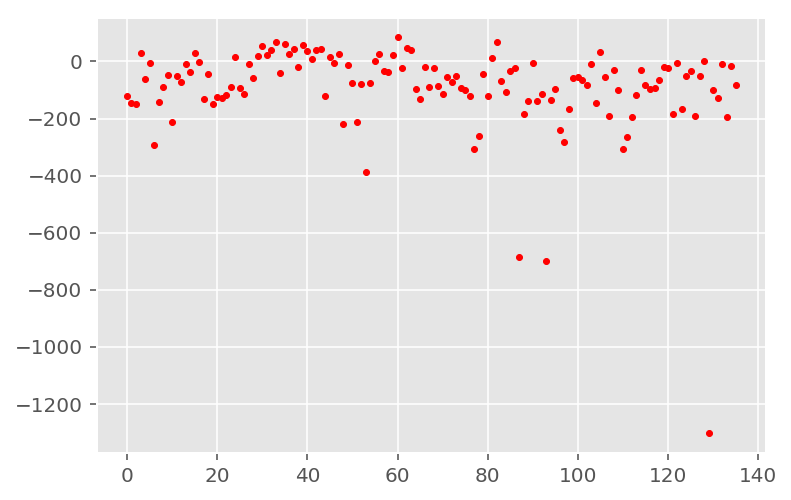

In [54]:
plt.scatter(id, e, c='red', marker='.')

In [55]:
pd.DataFrame({0 : id, 1: e})

,0,1
0,0,-120.955973
1,1,-143.925774
2,2,-147.824804
3,3,30.207791
4,4,-60.281651
5,5,-4.832976
6,6,-292.556461
7,7,-140.377160
8,8,-89.548963
9,9,-48.970134
